In [7]:
import pandas as pd
import numpy as np

## Exercise: classifying tissues based on the gene expression profile

Doctors usually ask a the same question when encountered with a metastatic tumor: **Where does it come from?** **What is the primary site?**. One approach to answer this questions would be to perform various clinical tests in order to determine the primary site. However, this procedure can be time consuming, tedious and expensive. Often, this metastasic tumors are never fully diagnosed and remain as cancers of unknown primary origin (CUP).

RNA-seq provides a very tempting strategy to solve the above mentioned problem. The gene expression profile is tissue is specific. Therefore, one approach to address the unknown-origin-problem could be solved by sequencing the RNA of the sample. Then we could compare the sample to known expression profiles from databases and classify the tissue specimen into one category.

In this exercise, we will do such a thing. We will train a neural network on gene expression profiles from databases with known tissues, and we will evaluate its performance at classifying gene expression profiles with the tissue being hidden from the neural network.




In [8]:
!wget https://github.com/Center-for-Health-Data-Science/IntroToML/raw/main/data/gtex_1000.csv.gz

--2022-05-20 10:36:52--  https://github.com/Center-for-Health-Data-Science/IntroToML/raw/main/data/gtex_1000.csv.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Center-for-Health-Data-Science/IntroToML/main/data/gtex_1000.csv.gz [following]
--2022-05-20 10:36:52--  https://raw.githubusercontent.com/Center-for-Health-Data-Science/IntroToML/main/data/gtex_1000.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9481366 (9,0M) [application/octet-stream]
Saving to: ‘gtex_1000.csv.gz’

gtex_1000.csv.gz    100%[===================>]   9,04M  29,3MB/s    in 0,3s    

2022-05-20 10:36:52 (29,3 MB/

## The data

The data is a subsample from the Genotype-Tissue Expression (GTEx) database. For this exercise, we have minimally process the data a bit: we have selected 7 tissues and a subset of 1000 genes. You can load the data, and see its raw version below.

In [10]:
gtex = pd.read_table("gtex_1000.csv.gz",sep='\t')
gtex

,ENSG00000122591.11,ENSG00000110934.10,ENSG00000112303.13,ENSG00000243943.9,ENSG00000200320.1,ENSG00000185523.6,ENSG00000002016.17,ENSG00000196290.14,ENSG00000171824.13,ENSG00000115459.17,...,ENSG00000180011.6,ENSG00000164124.10,ENSG00000244734.3,ENSG00000187581.2,ENSG00000213339.8,ENSG00000130165.10,ENSG00000005801.16,ENSG00000185915.5,ENSG00000144560.14,tissue
0,405969,7207,1849,76326,1137,0,57752,48599,283994,103733,...,327448,5471,18465,350,168016,132203,77422,155460,166033,Muscle - Skeletal
1,110743,4954,4145,59331,1421,0,44751,47289,130585,80527,...,302126,9517,534500,912,84383,36860,70953,22257,119196,Muscle - Skeletal
2,601549,5079,4575,122535,1548,0,74709,88950,382542,292433,...,270768,12160,176390,447,103221,206666,138026,80034,140739,Muscle - Skeletal
3,107785,4251,992,48109,263,0,32903,61342,187242,103506,...,154879,3359,232653,223,57992,99642,55399,26447,34862,Muscle - Skeletal
4,104541,2725,1358,37434,793,0,123826,45624,276829,101146,...,246964,2494,518473,705,120504,111607,46009,227114,144601,Muscle - Skeletal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,79761,19768,10206,156399,9039,208,122848,62718,314624,192105,...,195498,52029,734385,14,959388,229488,107154,123,329118,Pancreas
3378,20851,2991,2527,35698,2716,274,31757,21671,99782,59068,...,78579,17461,384240,0,338844,111479,44852,10,82292,Pancreas
3379,56853,8709,9006,93894,5211,0,64820,43218,176857,77350,...,140115,65180,3694,377,305473,112569,98811,267,197824,Pancreas
3380,52879,9946,6180,136779,7409,264,96992,35492,214014,127169,...,198793,54667,362916,228,557786,124295,111535,0,290844,Pancreas


As you can see in the las column of the dataframe, the tissues are enconded as strings, and pytorch does not support this. To address so, we will simply encode the tissues as numbers. Luckily, sklearn has a function for that!

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(gtex['tissue'])
gtex['tissue'] = le.transform(gtex['tissue'])

## An initial exploration of the data using PCA

Before diving "deep" into a neural network, we will explore the data a bit using a principal component analysis. This will reveal whether there is any signal (e.g. do tissues separate in the PCA?) we can try to capture with a machine learning algorithm. Furthermore, it will give us intuition about how complex are model should be.

In [13]:
from sklearn.decomposition import PCA


# log scale the data
x = gtex.loc[:, gtex.columns.drop('tissue')].values
x = np.log(x+0.01)

# fit pca 
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


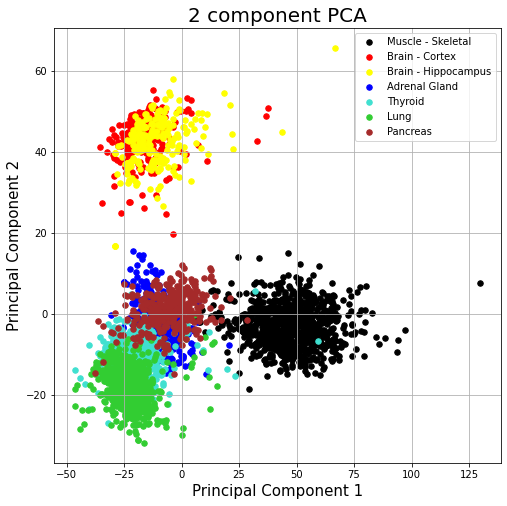

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# add tissues to PCs
finalDf = pd.concat([principalDf, gtex[['tissue']]], axis = 1)

#encode tissues back to strings
finalDf['tissue'] = le.inverse_transform(finalDf['tissue'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets  = ['Muscle - Skeletal','Brain - Cortex','Brain - Hippocampus','Adrenal Gland','Thyroid', 'Lung', 'Pancreas']
colors = ["black", "red", "yellow", "blue", 
          "turquoise", "limegreen", "brown"]  
cmap = ListedColormap(colors)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['tissue'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 30)
ax.legend(targets)
ax.grid()

From the PCA, it becomes apparent that tissues have different gene expression profiles. Let's try to create a neural network that classifies the samples given the gene expression values.

## Preliminaries: preparing the data for pytorch

In order to handle datasets, pytorch provides Dataset and DataLoader modules that help us to harmonize different datasets and fit them into pytorch requirements. To do so, we need implement dataset module that len (that calculates dataset length) and getitem (that queries data) methods.

In [16]:
from torch.utils.data import Dataset, DataLoader


class GeneExpressionDataset(Dataset):
    '''
    Creates a Dataset class for gene expression dataset
    gene_dim is the number of genes (features)
    The rows of the dataframe contain samples, and the 
    columns contain each gene expression value.
    
    - the last column contains the label: the tissue of
    origin.
    '''
    def __init__(self, gtex):
        '''
        Args:
            csv_file (string): path to csv file
        '''
        self.dataframe = gtex
        #convert labels to numbers
        self.le = preprocessing.LabelEncoder()
        self.dataframe['tissue'] = self.le.fit_transform(self.dataframe.iloc[:,-1])
        
    def __len__(self):
        return(len(self.dataframe))
    def __getitem__(self, idx):
        # get expression and labels
        expression = torch.tensor(self.dataframe.iloc[idx,0:-1].values).float()
        label = self.dataframe.iloc[idx,-1]
        return expression, label

Once we have define our dataloader, we need to define our neural network. 

In [17]:
import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 fully connected layers 
        self.fc1 = nn.Linear(in_features=1000, out_features=300)
        self.fc2 = nn.Linear(in_features=300, out_features=60)
        self.fc3 = nn.Linear(in_features=60, out_features=7)

    def forward(self, x):
        # pass data through the layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Finally, we can move to the main parts. We first define a function to calculate accuracy, then dataloaders, and finally define our network, the loss function (we will use the cross-entropy for this) and the Adam optimizer.

In [62]:
from sklearn.model_selection import train_test_split
from torch import optim
import torch
train,test = train_test_split(gtex,test_size=0.2,random_state=42)

def multi_acc(y_pred, y_test):
    """Function that calculates classification accuracy"""

    
    correct_pred = (y_pred.max(dim=1) == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc



gtex_train = GeneExpressionDataset(train)
gtex_test = GeneExpressionDataset(test)
train_loader = torch.utils.data.DataLoader(gtex_train, batch_size=32, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(gtex_test, batch_size=32, num_workers=0, shuffle=True)

epochs = 20

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [63]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    train_acc = []
    test_acc  = []
    
    for inputs,labels in train_loader:
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        correct_pred = outputs.argmax(dim=1) == labels
        acc = correct_pred.sum() / len(correct_pred)

        epoch_train_loss += loss.item()
        train_acc.append(acc)
    for inputs,labels in test_loader:
        # forward only
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_test_loss += loss.item()
        
        correct_pred = outputs.argmax(dim=1) == labels
        acc = correct_pred.sum() / len(correct_pred)
        test_acc.append(acc)
        
    #save some stats
    epoch_train_loss = np.round(epoch_train_loss/len(gtex_train),4)
    epoch_test_loss = np.round(epoch_test_loss/len(gtex_test),4)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)
                                
    print("Epoch:", epoch)
    print("train loss:", epoch_train_loss,"test loss:", epoch_test_loss)
    print("train acc:", np.mean(train_acc).round(4),"test accuracy:", np.mean(test_acc).round(4))

Epoch: 0
train loss: 333.4073 test loss: 28.7231
train acc: 0.9258 test accuracy: 0.9659
Epoch: 1
train loss: 11.2908 test loss: 31.6062
train acc: 0.9875 test accuracy: 0.9787
Epoch: 2
train loss: 8.557 test loss: 23.331
train acc: 0.9886 test accuracy: 0.9801
Epoch: 3
train loss: 4.5372 test loss: 25.2227
train acc: 0.9912 test accuracy: 0.983
Epoch: 4
train loss: 6.0246 test loss: 32.2032
train acc: 0.9897 test accuracy: 0.9787
Epoch: 5
train loss: 2.8962 test loss: 33.0912
train acc: 0.9938 test accuracy: 0.9787
Epoch: 6
train loss: 3.2553 test loss: 21.0139
train acc: 0.9897 test accuracy: 0.9872
Epoch: 7
train loss: 12.5871 test loss: 27.1813
train acc: 0.9879 test accuracy: 0.9815
Epoch: 8
train loss: 1.9561 test loss: 25.6605
train acc: 0.9945 test accuracy: 0.983
Epoch: 9
train loss: 4.6571 test loss: 41.587
train acc: 0.9938 test accuracy: 0.973
Epoch: 10
train loss: 8.0733 test loss: 21.1291
train acc: 0.9904 test accuracy: 0.9872
Epoch: 11
train loss: 1.6448 test loss: 28.0

Lets now plot the loss curves

Text(0, 0.5, 'Loss')

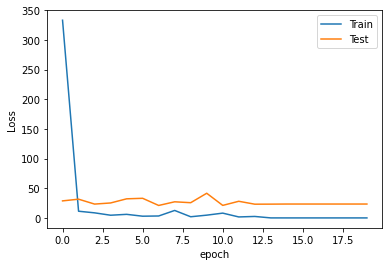

In [66]:
plt.plot(np.arange(epoch+1),train_loss,label="Train")
plt.plot(np.arange(epoch+1),test_loss,label="Test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")